In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import zipfile

In [3]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

In [4]:
%cd /content/drive/MyDrive/Kaggle/

/content/drive/MyDrive/Kaggle


In [8]:
!kaggle datasets download -d hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images

 98% 97.0M/98.7M [00:05<00:00, 25.7MB/s]
100% 98.7M/98.7M [00:05<00:00, 20.2MB/s]


In [5]:
!ls

DL.zip	kaggle.json  melanoma-skin-cancer-dataset-of-10000-images.zip


In [6]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Kaggle/DL.zip")
zip_ref.extractall("/tmp")
zip_ref.close()

In [30]:
import numpy as np
import os
import cv2
import shutil
import random as rn
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.models import Model

In [8]:
train_dir ="/tmp/DL/train"
test_dir = "/tmp/DL/test"

In [9]:
print(os.listdir("/tmp/DL"))

['test', 'train']


In [10]:
print("Train classes", os.listdir(train_dir))
print("Test classes", os.listdir(test_dir))

Train classes ['benign', 'malignant']
Test classes ['benign', 'malignant']


In [35]:
batch_size = 32
img_height = 224
img_width = 224

In [36]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2093 files belonging to 2 classes.
Using 1675 files for training.


In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2093 files belonging to 2 classes.
Using 418 files for validation.


In [38]:
class_names = train_ds.class_names
print(class_names)

['benign', 'malignant']


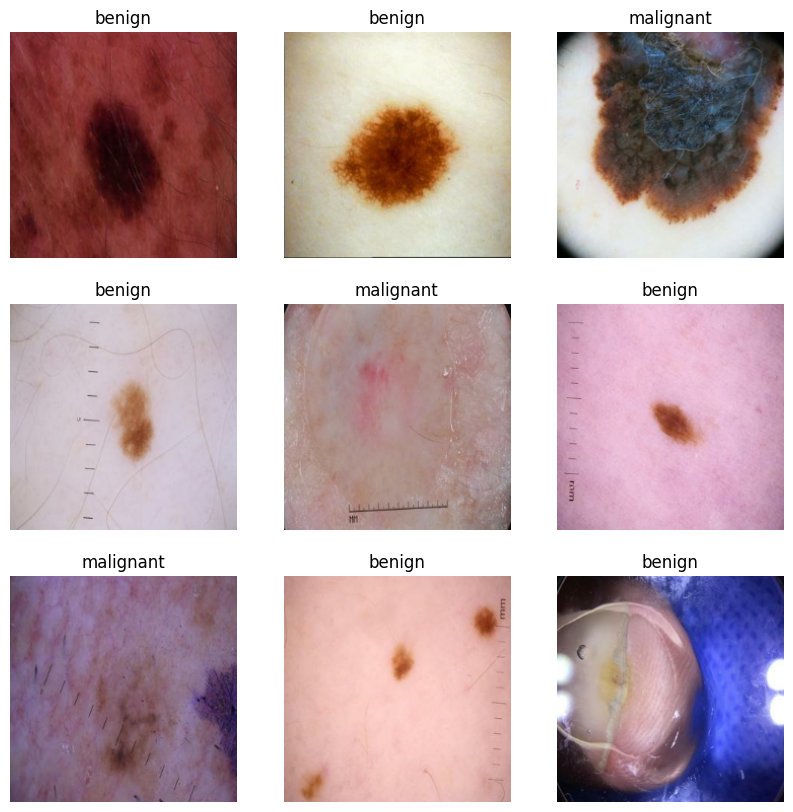

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [40]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [41]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [25]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
vgg = VGG16(input_shape=[224, 224] + [3], weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 4s 0us/step


In [42]:
vgg.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [43]:
for layer in vgg.layers:
  layer.trainable = False

In [44]:
num_classes = 2

In [45]:
x = layers.Flatten()(vgg.output)
prediction = layers.Dense(num_classes, activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [46]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [49]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [51]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  steps_per_epoch=5,
)

Epoch 1/10
5/5 [==============================] - 2s 525ms/step - loss: 0.5421 - accuracy: 0.9250 - val_loss: 2.1167 - val_accuracy: 0.8589
Epoch 2/10
5/5 [==============================] - 2s 517ms/step - loss: 0.7283 - accuracy: 0.9500 - val_loss: 1.9694 - val_accuracy: 0.8756
Epoch 3/10
5/5 [==============================] - 2s 521ms/step - loss: 0.3805 - accuracy: 0.9500 - val_loss: 1.9350 - val_accuracy: 0.8852
Epoch 4/10
5/5 [==============================] - 2s 524ms/step - loss: 0.5909 - accuracy: 0.9563 - val_loss: 1.9294 - val_accuracy: 0.8804
Epoch 5/10
5/5 [==============================] - 2s 522ms/step - loss: 0.7510 - accuracy: 0.9500 - val_loss: 1.9789 - val_accuracy: 0.8947
Epoch 6/10
5/5 [==============================] - 2s 524ms/step - loss: 0.5194 - accuracy: 0.9375 - val_loss: 2.1122 - val_accuracy: 0.8684
Epoch 7/10
5/5 [==============================] - 2s 524ms/step - loss: 0.3616 - accuracy: 0.9563 - val_loss: 2.1721 - val_accuracy: 0.8828
Epoch 8/10
5/5 [====

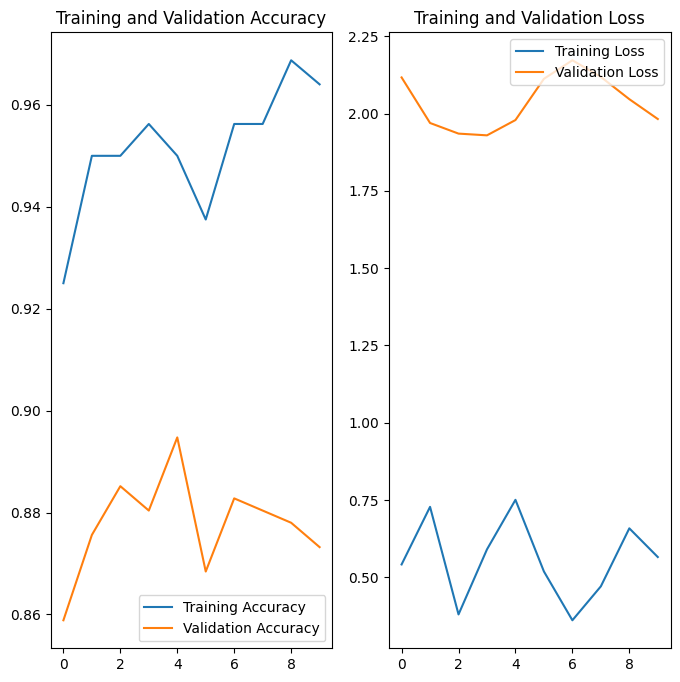

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()